In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import pickle

In [3]:
from experiments import EGUOptimalSetup
from experiments import utilities as utils
from bayesinverse import Regression

In [4]:
config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/egu_optimal_setup/config.yaml"
)

exp = EGUOptimalSetup(config_path)
# basic_setup.run()


sensors 0.002764657139778137
emissions 3.6034030467271805
transport 5.9564047157764435


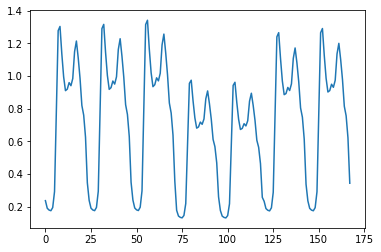

In [5]:
plt.plot(utils.stack_xr(exp.emissions.truth.mean("source_group")))

In [6]:
source_group_path = Path(
    "/mnt/data/users/rmaiwald/GRAMM-GRAL/emissions/pickle_jar/source_groups_infos.csv"
)
source_group_df = pd.read_csv(
    source_group_path,
    index_col=0,
)


In [7]:
path = Path("/mnt/data/users/rmaiwald/")

with open(
    path / "GRAMM-GRAL/emissions/heat_traffic/tno_districts_gdf.pickle",
    "rb",
) as file:
    tno_districts_gdf = pickle.load(file)


In [8]:
abs_emissions = exp.emissions.absolute_emissions

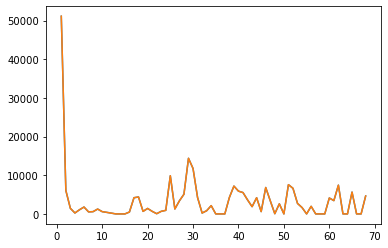

In [9]:
plt.plot(np.arange(len(abs_emissions)) + 1, abs_emissions)
plt.plot(source_group_df["CO2[kg/hour]"])

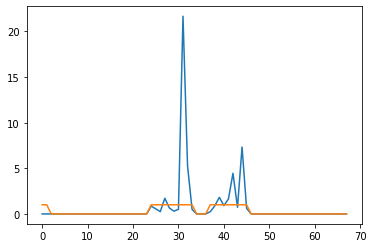

In [10]:
plt.plot(exp.emissions.get_mean_TNO())
plt.plot(exp.emissions.get_TNO())

In [11]:
[(source_group_df["source_type"] == "TNO area").values]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])]

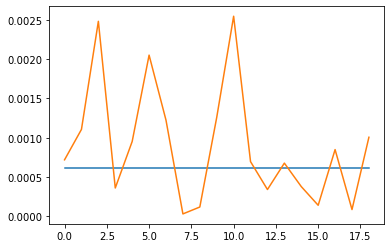

In [12]:
plt.plot(
    (exp.emissions.get_mean_TNO() * exp.emissions.absolute_emissions)[
        (source_group_df["source_type"] == "TNO area").values
    ]
    / tno_districts_gdf["area"]
)
plt.plot(
    (exp.emissions.get_TNO() * exp.emissions.absolute_emissions)[
        (source_group_df["source_type"] == "TNO area").values
    ]
    / tno_districts_gdf["area"]
)


In [13]:
# Sanity check
print((exp.emissions.get_mean_TNO_with_points() * exp.emissions.absolute_emissions).sum())
print((exp.emissions.get_TNO() * exp.emissions.absolute_emissions).sum())

<xarray.DataArray ()>
array(150418.76026199)
<xarray.DataArray ()>
array(150418.76026199)


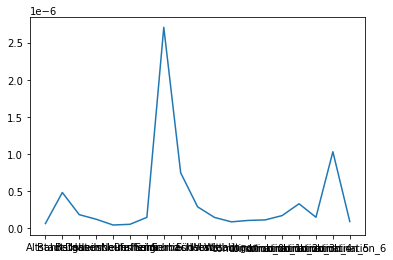

In [14]:
plt.plot(
    exp.emissions.get_mean_TNO()[source_group_df["source_type"] == "TNO area"]
    / tno_districts_gdf["area"] 
)


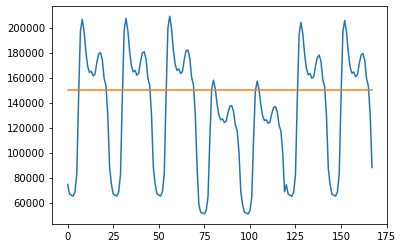

In [15]:
plt.plot(exp.emissions.truth_absolute.sum("source_group"))
plt.plot(exp.emissions.prior_absolute.sum("source_group"))
pass

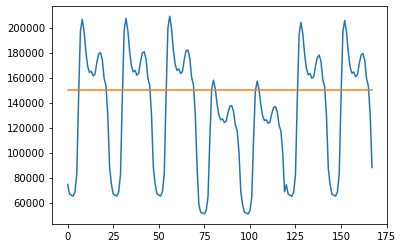

In [16]:
plt.plot(exp.emissions.truth_absolute.sum("source_group"))
plt.plot(exp.emissions.prior_absolute.sum("source_group"))
pass

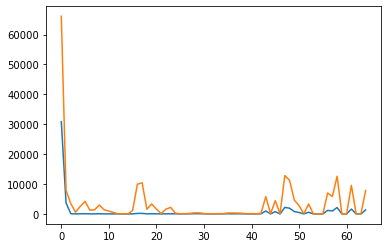

In [17]:
plt.plot(exp.emissions.truth_absolute.min("time_state"))
plt.plot(exp.emissions.truth_absolute.max("time_state"))


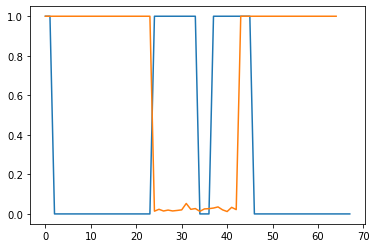

In [18]:
plt.plot(exp.emissions.get_TNO())
plt.plot(exp.emissions.truth.mean("time_state"))


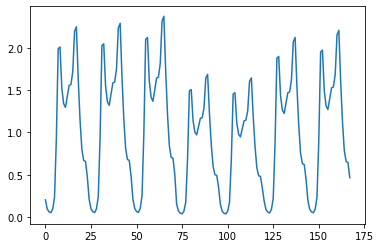

In [19]:
plt.plot(exp.emissions.truth.isel(source_group=10))

In [20]:
n_processes = 32
exp.K = exp.transport.get_transport(
    exp.sensors.n_sensors, exp.sensors.get_index(), exp.emissions, n_processes
)


loop start 18.291557177901268
loop end 18.47324937582016


In [21]:
exp.reg = Regression(
    y=utils.stack_xr(
        exp.K @ exp.emissions.truth
        + exp.sensors.get_noise()
    ).values,
    K=utils.stack_xr(exp.K).values,
    x_prior=utils.stack_xr(exp.emissions.prior).values,
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
    y_covariance=utils.stack_xr(
        exp.sensors.get_covariance()
    ).values,
)
x_est, res, rank, s = exp.reg.fit()


In [22]:
posterior = exp.emissions.to_xr(x_est)


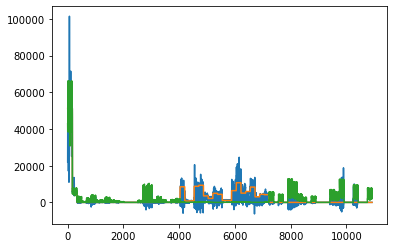

In [23]:
plt.plot(utils.stack_xr(utils.unstack_xr(posterior) * exp.emissions.absolute_emissions))
plt.plot(utils.stack_xr(exp.emissions.prior_absolute))
plt.plot(utils.stack_xr(exp.emissions.truth_absolute))

In [24]:
posterior_covariance = exp.emissions.to_xr(exp.reg.get_posterior_covariance())

In [25]:
error_reduction = exp.emissions.to_xr(exp.reg.get_error_reduction())

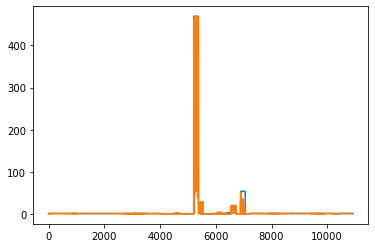

In [26]:
plt.plot(utils.stack_xr(exp.emissions.prior_covariance))
plt.plot(np.diag(posterior_covariance))

Mean error reduction: <xarray.DataArray ()>
array(18.53752969)


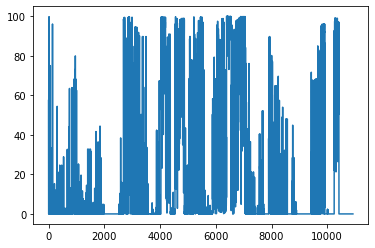

In [27]:
plt.plot(error_reduction)
print(f"Mean error reduction: {error_reduction.mean()}")

In [28]:
posterior = utils.unstack_xr(posterior) * exp.emissions.absolute_emissions

In [34]:
rmse = utils.compute_rmse(
    posterior.sum("source_group"), exp.emissions.truth_absolute.sum("source_group")
).values
print(f"RMSE: {int(rmse)} kg/h")
mean_total_emissions = exp.emissions.truth_absolute.sum("source_group").mean().values
print(f"of mean total emissions {int(mean_total_emissions)} kg/h")
mean_total_posterior = posterior.sum("source_group").mean().values
print(f"of mean total posterior {int(mean_total_posterior)} kg/h")
print(f"which equals a rmse of {int(rmse/mean_total_emissions*100)}%")
mean_total_prior = exp.emissions.prior_absolute.sum("source_group").mean().values
print(f"from an prior of {int(mean_total_prior)} kg/h")
rmse_prior = utils.compute_rmse(
    exp.emissions.prior_absolute.sum("source_group"), exp.emissions.truth_absolute.sum("source_group")
).values
print(f"with an rmse of {int(rmse_prior)} kg/h")
print(f"which equals a rmse of {int(rmse_prior/mean_total_emissions*100)}%")



RMSE: 30047 kg/h
of mean total emissions 132534 kg/h
of mean total posterior 121155 kg/h
which equals a rmse of 22%
from an prior of 150418 kg/h
with an rmse of 49910 kg/h
which equals a rmse of 37%


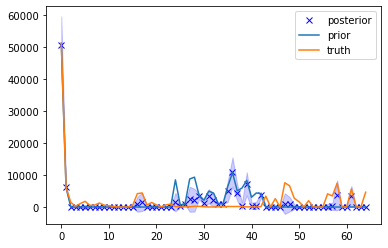

In [30]:
mean = posterior.mean("time_state")
std = posterior.std("time_state")
line = plt.plot(mean, "bx", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

plt.plot(exp.emissions.prior_absolute.mean("time_state"), label="prior")
plt.plot(exp.emissions.truth_absolute.mean("time_state"), label="truth")
plt.legend()

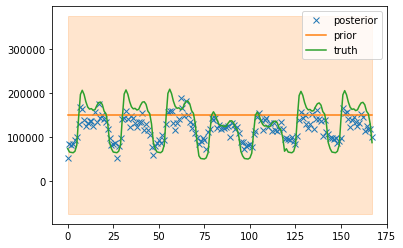

In [31]:
mean = posterior.sum("source_group")
# std = np.tile(posterior.mean("source_group").std("time_state"), len(mean))
# std = np.sqrt(utils.var_of_sum(posterior_covariance))
line = plt.plot(mean, "x", label="posterior")[0]
# plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean = exp.emissions.prior_absolute.sum("source_group")
std = np.sqrt(
    exp.emissions.prior_variance
    * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
).sum("source_group")
line = plt.plot(mean, label="prior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

plt.plot(exp.emissions.truth_absolute.sum("source_group"), label="truth")
plt.legend()


0.6818239921249126
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.447910147260747
0.18989594599867532
0.0
1.2971408935823083
1.0168841627573857
1.0435290041408916
0.0
1.0435290041408916
0.0
0.0
0.0
0.0
0.0
0.6818239921249298
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6818239921249298
0.0
0.11244387943135906
0.14800497573965887
0.9742550855987769
0.9334152645650485
0.13608025557624404
0.3255551387822334
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3847106736743118
1.3946356498052965
0.0
0.18989594599874748
0.0
0.4668926018154555
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1654467957946388
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4479101472607445
1.4479101472607445
1.6154638618199868
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

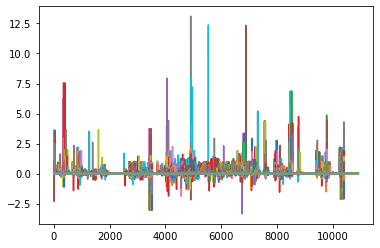

In [32]:
averaging_kernel = exp.reg.get_averaging_kernel()
for i in range(averaging_kernel.shape[0]):
    kernel = averaging_kernel[i]
    plt.plot(kernel, label=kernel.sum())
    print(kernel.sum())
# plt.legend()


In [33]:
im = plt.imshow(
    exp.emissions.truth_absolute.values
    * exp.reg.get_averaging_kernel()
    * exp.emissions.truth_absolute.values.T
)
plt.colorbar(im)


ValueError: operands could not be broadcast together with shapes (65,168) (10920,10920) 

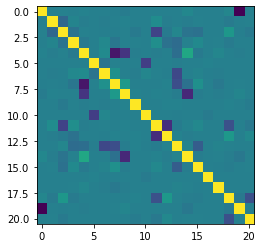

In [ ]:
plt.imshow(exp.reg.get_correlation())

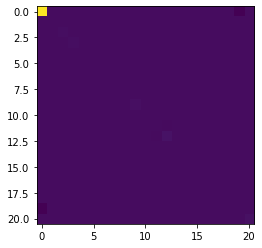

In [ ]:
plt.imshow(
    exp.emissions.truth_absolute.values
    * exp.reg.get_posterior_covariance()
    * exp.emissions.truth_absolute.values.T
)


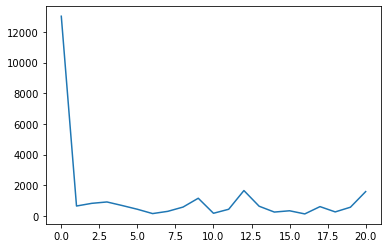

In [ ]:
plt.plot(
    np.sqrt(np.diag(exp.reg.get_posterior_covariance()))
    * exp.emissions.truth_absolute.values[:, 0]
)


In [ ]:
exp.reg.get_information_content(), exp.reg.get_dof_signal(), exp.reg.get_dof_noise()

(28.371533660094514, 16.663266611992587, 4.3367333880074135)